# CycleGan Implementation - Hugo Peralta Muñoz

Primero de todo comenzaremos por cargar todas las imágenes con las que entrenaremos el modelo de *CycleGAN*, las imágenes del entrenamiento las saco usando *Flickr API* del paper oficial o de este dataset de [Kaggle](https://www.kaggle.com/datasets/suyashdamle/cyclegan/data).

## Importación de librerías

In [54]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random
from keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, LeakyReLU, Activation, Concatenate, BatchNormalization
from tensorflow.keras.models import Model

tf.compat.v1.enable_eager_execution
print(tf.executing_eagerly())

True


Crearemos un método para cargar las imágenes del directorio que queramos descargar:

In [35]:
def load_images(folder_path, size=(256,256)):
    data_list = list()

    for filename in os.listdir(folder_path):
        full_path = os.path.join(folder_path, filename)
        pixels = load_img(full_path, target_size=size)
        pixels = img_to_array(pixels)
        data_list.append(pixels)

    return np.asarray(data_list)

Cargaremos ahora las imágenes.

In [36]:
folder_path_test_A = "testA/"
folder_path_test_B = "testB/"
folder_path_train_A = "trainA/"
folder_path_train_B = "trainB/"

test_A = load_images(folder_path_test_A)
test_B = load_images(folder_path_test_B)
train_A = load_images(folder_path_train_A)
train_B = load_images(folder_path_train_B)

test_A.shape, test_B.shape, train_A.shape, train_B.shape

((309, 256, 256, 3),
 (238, 256, 256, 3),
 (1231, 256, 256, 3),
 (962, 256, 256, 3))

Vamos a combinar los datasets de entrenamiento y de prueba en uno solo, uno por cada tipo.

In [37]:
dataset_A = np.vstack((train_A, test_A))
dataset_B = np.vstack((train_B, test_B))

dataset_A.shape, dataset_B.shape

((1540, 256, 256, 3), (1200, 256, 256, 3))

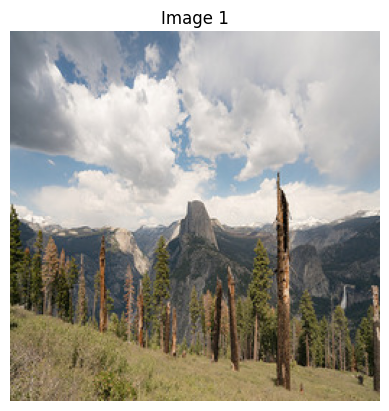

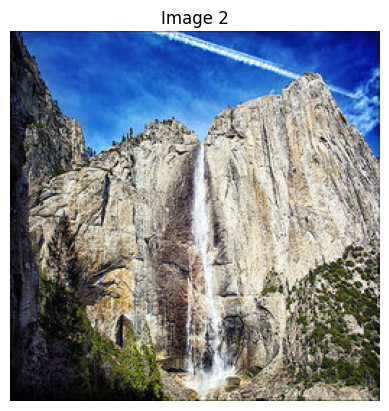

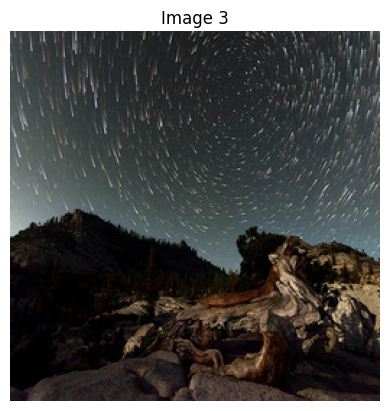

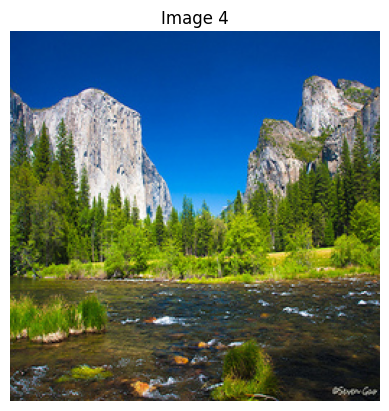

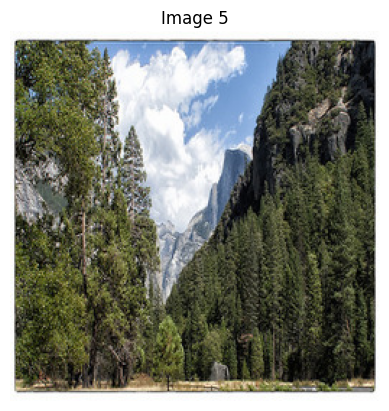

In [38]:
# Mostramos una imagen de ejemplo del dataset A
sample_images = random.sample(list(dataset_A), 5)
count = 1
for image in sample_images:
    image = image / 255.0
    plt.title(f"Image {count}")
    plt.imshow(image)
    plt.axis("off")
    count+=1
    plt.show()

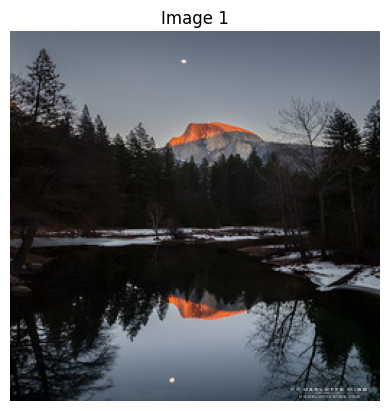

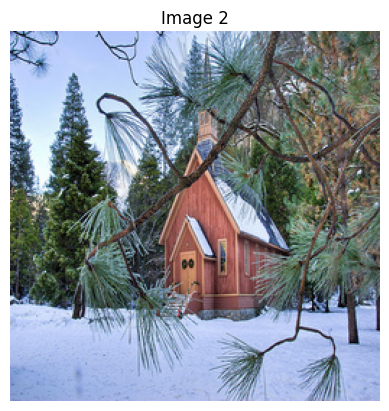

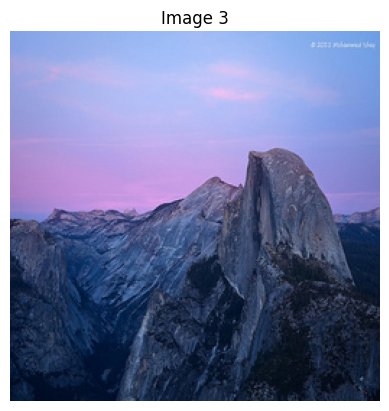

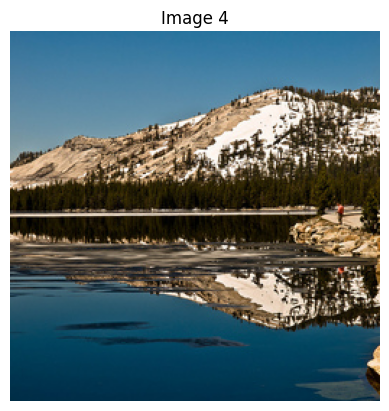

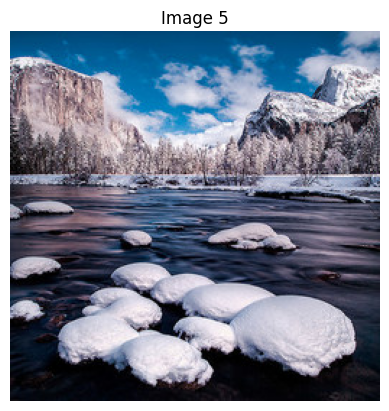

In [39]:
# Mostrar una imagen de ejemplo del dataset B
sample_images = random.sample(list(dataset_B), 5)
count = 1
for image in sample_images:
    image = image / 255.0
    plt.title(f"Image {count}")
    plt.imshow(image)
    plt.axis("off")
    count+=1
    plt.show()

In [40]:
# Normalizamos las imágenes de los datasets, rango entre [-1, 1]
dataset_A = (dataset_A / 127.5) - 1
dataset_B = (dataset_B / 127.5) - 1

## Generador

In [41]:
def build_generator(input_shape=(256, 256, 3)):
    inputs = Input(shape=input_shape)
    
    # Encoder
    e1 = Conv2D(64, kernel_size=4, strides=2, padding='same')(inputs)
    e1 = LeakyReLU(0.2)(e1)
    
    e2 = Conv2D(128, kernel_size=4, strides=2, padding='same')(e1)
    e2 = BatchNormalization()(e2)
    e2 = LeakyReLU(0.2)(e2)
    
    # Decoder
    d1 = Conv2DTranspose(64, kernel_size=4, strides=2, padding='same')(e2)
    d1 = BatchNormalization()(d1)
    d1 = Activation('relu')(d1)
    
    # Conexión de skip: se concatena con e1 para preservar detalles
    d1 = Concatenate()([d1, e1])
    
    d2 = Conv2DTranspose(3, kernel_size=4, strides=2, padding='same')(d1)
    outputs = Activation('tanh')(d2)  
    
    return Model(inputs, outputs, name='Generator')

## Disciminador

In [42]:
def build_discriminator(input_shape=(256, 256, 3)):
    inputs = Input(shape=input_shape)
    
    d1 = Conv2D(64, kernel_size=4, strides=2, padding='same')(inputs)
    d1 = LeakyReLU(0.2)(d1)
    
    d2 = Conv2D(128, kernel_size=4, strides=2, padding='same')(d1)
    d2 = BatchNormalization()(d2)
    d2 = LeakyReLU(0.2)(d2)
    
    # Capa final para clasificar
    d3 = Conv2D(1, kernel_size=4, strides=1, padding='same')(d2)
    
    return Model(inputs, d3, name='Discriminator')

## Creación de los modelos

In [43]:
generator_A2B = build_generator()
generator_B2A = build_generator()
discriminator_A = build_discriminator()
discriminator_B = build_discriminator()

In [45]:
generator_A2B.summary(), discriminator_A.summary()

Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 128, 128,  │      3,136 │ input_layer_4[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_8       │ (None, 128, 128,  │          0 │ conv2d_10[0][0]   │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 64, 64,    │    131,200 │ leaky_re_lu_8[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_9       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_4  │ (None, 128, 128,  │    131,136 │ leaky_re_lu_9[0]… │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 128, 128,  │          0 │ activation_4[0][… │
│ (Concatenate)       │ 128)              │            │ leaky_re_lu_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_5  │ (None, 256, 256,  │      6,147 │ concatenate_2[0]… │
│ (Conv2DTranspose)   │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 256, 256,  │          0 │ conv2d_transpose… │
│ (Activation)        │ 3)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 272,387 (1.04 MB)

 Trainable params: 272,003 (1.04 MB)

 Non-trainable params: 384 (1.50 KB)

Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 128, 128, 64)   │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 64, 64, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 64, 64, 1)      │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 136,897 (534.75 KB)

 Trainable params: 136,641 (533.75 KB)

 Non-trainable params: 256 (1.00 KB)

(None, None)

## Funciones de pérdida y ciclo de entrenamiento

In [47]:
# Definición de pérdidas básicas
mse_loss = tf.keras.losses.MeanSquaredError()
mae_loss = tf.keras.losses.MeanAbsoluteError()

In [48]:
def generator_loss(fake_output):
    return mse_loss(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = mse_loss(tf.ones_like(real_output), real_output)
    fake_loss = mse_loss(tf.zeros_like(fake_output), fake_output)
    return (real_loss + fake_loss) * 0.5

In [49]:
def cycle_loss(real_image, cycled_image, lambda_cycle=10):
    loss = mae_loss(real_image, cycled_image)
    return lambda_cycle * loss

def identity_loss(real_image, same_image, lambda_identity=5):
    loss = mae_loss(real_image, same_image)
    return lambda_identity * loss

In [50]:
# Optimizadores
gen_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
disc_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## Entrenamiento

In [ ]:
@tf.function # Esto compila la funcion de entrenamiento
def train_step(real_A, real_B, lambda_cycle=10, lambda_identity=5):
    with tf.GradientTape(persistent=True) as tape:
        # Generar imágenes falsas
        fake_B = generator_A2B(real_A, training=True)
        fake_A = generator_B2A(real_B, training=True)
        
        # Ciclo de consistencia
        cycled_A = generator_B2A(fake_B, training=True)
        cycled_B = generator_A2B(fake_A, training=True)
        
        # Pérdida de identidad (opcional)
        same_A = generator_B2A(real_A, training=True)
        same_B = generator_A2B(real_B, training=True)
        
        # Salidas de los discriminadores
        disc_real_A = discriminator_A(real_A, training=True)
        disc_real_B = discriminator_B(real_B, training=True)
        disc_fake_A = discriminator_A(fake_A, training=True)
        disc_fake_B = discriminator_B(fake_B, training=True)
        
        # Pérdidas de los generadores
        loss_GAN_A2B = generator_loss(disc_fake_B)
        loss_GAN_B2A = generator_loss(disc_fake_A)
        loss_cycle_A = cycle_loss(real_A, cycled_A, lambda_cycle)
        loss_cycle_B = cycle_loss(real_B, cycled_B, lambda_cycle)
        loss_id_A = identity_loss(real_A, same_A, lambda_identity)
        loss_id_B = identity_loss(real_B, same_B, lambda_identity)
        
        total_gen_loss = loss_GAN_A2B + loss_GAN_B2A + loss_cycle_A + loss_cycle_B + loss_id_A + loss_id_B
        
        # Pérdidas de los discriminadores
        disc_A_loss = discriminator_loss(disc_real_A, disc_fake_A)
        disc_B_loss = discriminator_loss(disc_real_B, disc_fake_B)
    
    # Aplicar gradientes
    gen_gradients = tape.gradient(total_gen_loss, 
                                  generator_A2B.trainable_variables + generator_B2A.trainable_variables)
    disc_A_gradients = tape.gradient(disc_A_loss, discriminator_A.trainable_variables)
    disc_B_gradients = tape.gradient(disc_B_loss, discriminator_B.trainable_variables)
    
    gen_optimizer.apply_gradients(zip(gen_gradients, 
                                      generator_A2B.trainable_variables + generator_B2A.trainable_variables))
    disc_optimizer.apply_gradients(zip(disc_A_gradients, discriminator_A.trainable_variables))
    disc_optimizer.apply_gradients(zip(disc_B_gradients, discriminator_B.trainable_variables))
    
    return {
        'total_gen_loss': total_gen_loss,
        'disc_A_loss': disc_A_loss,
        'disc_B_loss': disc_B_loss
    }

In [59]:
num_epochs = 10  # Cambia esto al número de épocas deseadas

for epoch in range(num_epochs):
    losses = train_step(dataset_A, dataset_B)

## Generación de imágenes

In [60]:
def show_generated_images(generator, real_images, n=5):
    fake_images = generator(real_images, training=False)
    # Desnormalizar de [-1,1] a [0,1]
    fake_images = (fake_images + 1) / 2.0
    plt.figure(figsize=(15,3))
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(fake_images[i])
        plt.axis('off')
    plt.show()

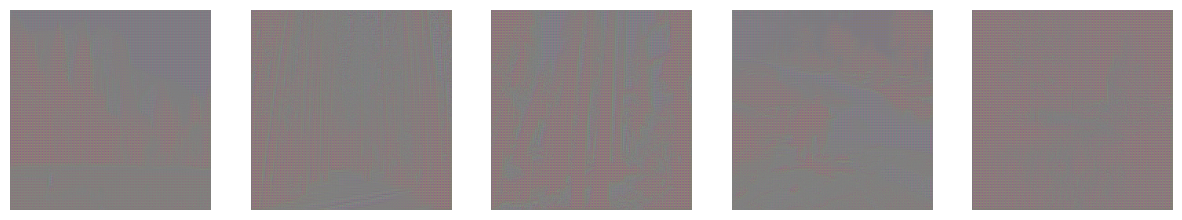

In [61]:
real_A = dataset_A[:5]
show_generated_images(generator_A2B, real_A)